## 0 Импорты + Загрузка данных 

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import typing as t
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from tqdm.notebook import tqdm
from IPython.display import HTML
from dataclasses import dataclass
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize


In [2]:
data_folder = "/home/gleb_galagan/tbank_recsys/sirius_recsys/sirius-2025-recsys/data/"
train = pl.read_parquet(data_folder + "train.pq")
books = pl.read_parquet('/home/gleb_galagan/tbank_recsys/baseline_solution/books_all_embs.parquet')
# books_descr = pl.read_parquet('/home/gleb_galagan/tbank_recsys/baseline_solution/books_title_description_emb.parquet')
test_exploded = pl.read_parquet(data_folder + "test.pq")
test = test_exploded.group_by("user_id", maintain_order=True).agg(pl.col("item_id"))

In [3]:
# ===========================================================================================
# Здесь закомменчен препроцессинг над books который я потом сохранил в books_all_embs.parquet
# ===========================================================================================

# books = books.join(
#     books_descr.select(['item_id', 'description_embeddings']),
#     on='item_id',
#     how='left'  # Keep all rows from books, even if no match in books_emb
# )

# tags_as_strings = books["tags"].map_elements(lambda x: " ".join(x), return_dtype=pl.String)

# vectorizer = CountVectorizer(min_df=0.2, max_df=0.8, max_features=32)
# X = vectorizer.fit_transform(tags_as_strings)
# embeddings = normalize(X.toarray()).tolist()

# books = books.with_columns(
#     pl.Series("embedding_tags", embeddings)
# )


# def standardize_embedding(embedding, target_dim=1024):
#     if embedding is None:  # Handle null values
#         return [0.0] * target_dim
#     embedding = np.array(embedding, dtype=np.float32)
#     if len(embedding) == target_dim:
#         return embedding.tolist()
#     elif len(embedding) < target_dim:
#         # Pad with zeros
#         return np.pad(embedding, (0, target_dim - len(embedding)), mode='constant').tolist()
#     else:
#         # Truncate to target dimension
#         return embedding[:target_dim].tolist()

# # Assume books and books_emb are your DataFrames
# # Standardize image_embedding in books DataFrame
# books = books.with_columns(
#     pl.col('image_embedding').map_elements(
#         lambda x: standardize_embedding(x, target_dim=1024),
#         return_dtype=pl.List(pl.Float32)
#     )
# )
# books.write_parquet('/home/gleb_galagan/tbank_recsys/baseline_solution/books_all_embs.parquet')


In [3]:
n_books = books.shape[0]
print(f"N books: {n_books}")

n_cold_books = n_books - train["item_id"].n_unique()
print(f"N 'cold' books: {n_cold_books}")

N books: 34322
N 'cold' books: 3022


## Класс для валидации

In [10]:
# ACHTUNG! DO NOT TOUCH

@dataclass
class AtKMetric(ABC):
    k: int

    @property
    @abstractmethod
    def name(self) -> str:
        raise NotImplementedError

    @property
    def full_name(self) -> str:
        return f"{self.name}@{self.k}"

    @abstractmethod
    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        raise NotImplementedError


class NDCG(AtKMetric):
    @property
    def name(self) -> str:
        return "ndcg"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        def _dcg(scores: np.ndarray) -> float:
            # Handle empty arrays
            if len(scores) == 0:
                return 0.0
            # Use vectorized operations for better performance
            positions = np.arange(1, len(scores) + 1, dtype=np.float64)
            return np.sum((np.power(2, scores) - 1) / np.log2(positions + 1))

        def ndcg(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty predictions or ground truth
            if not predicted or not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Create relevance scores (1 for relevant items, 0 otherwise)
            relevance = np.array([1 if x in gt_items else 0 for x in predicted], dtype=np.float64)
            
            rank_dcg = _dcg(relevance)
            if rank_dcg == 0.0:
                return 0.0
                
            # Ideal DCG: sort ground truth by relevance (all 1s) and take top-k
            ideal_relevance = np.ones(min(len(gt_items), self.k), dtype=np.float64)
            ideal_dcg = _dcg(ideal_relevance)
            
            if ideal_dcg == 0.0:
                return 0.0
                
            return rank_dcg / ideal_dcg

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: ndcg(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


class Recall(AtKMetric):
    @property
    def name(self) -> str:
        return "recall"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        def recall(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty ground truth
            if not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Calculate intersection
            intersection = len(set(gt_items).intersection(set(predicted)))
            return intersection / len(gt_items)

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: recall(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


def coverage(df: pl.DataFrame, n_items_in_catalog: int, preds_col: str = "preds") -> float:
    if n_items_in_catalog <= 0:
        return 0.0
        
    unique_recommended = df.select(
        pl.col(preds_col).explode().n_unique()
    ).item()
    return unique_recommended / n_items_in_catalog


def evaluate_recommender(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    n_items_in_catalog: int = n_books,
    k: int = 10,
) -> dict:
    metrics = [
        NDCG(k=k),
        Recall(k=k),
    ]
    result = {}
    
    # Create a copy to avoid modifying the original dataframe
    result_df = df.clone()
    
    for metric in metrics:
        result_df = result_df.with_columns(
            metric(preds_col=model_preds_col, ground_truth_col=ground_truth_col)
        )
        result[metric.full_name] = round(result_df.select(pl.col(metric.full_name).mean()).item(), 3)

    if n_items_in_catalog is not None:
        result["coverage"] = round(coverage(result_df, n_items_in_catalog, preds_col=model_preds_col), 3)
    
    return result

NOTE: Сказали не трогать класс выше, не трогаю

In [6]:
# evaluation по сплиту холодных и теплых айтемов

def evaluate_with_cold_split(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    cold_items: set[int] = None,
    n_items_in_catalog: int = None,
    k: int = 10,
) -> dict:
    metrics = [NDCG(k=k), Recall(k=k)]
    result = {}

    # помечаем, есть ли в ground_truth холодные айтемы
    df = df.with_columns(
        pl.col(ground_truth_col)
        .list.eval(pl.element().is_in(cold_items))
        .list.any()
        .alias("has_cold")
    )

    # считаем по сплитам
    for split_name, mask in [("cold", pl.col("has_cold")),
                             ("warm", ~pl.col("has_cold"))]:
        split_df = df.filter(mask)
        if split_df.height == 0:
            continue

        for metric in metrics:
            split_df = split_df.with_columns(
                metric(preds_col=model_preds_col, ground_truth_col=ground_truth_col)
            )
            result[f"{metric.full_name}_{split_name}"] = round(
                split_df.select(pl.col(metric.full_name).mean()).item(), 3
            )

        if n_items_in_catalog is not None:
            result[f"coverage_{split_name}"] = round(
                coverage(split_df, n_items_in_catalog, preds_col=model_preds_col), 3
            )

    return result

In [7]:
all_books = set(books['item_id']) 
train_books = set(train['item_id'])
cold_books = all_books - train_books
hot_books = all_books & train_books


# hot_set = 
print(f'Hot books {len(hot_books)}\n\nCold books {len(cold_books)}')

Hot books 31300

Cold books 3022


## Новые метрики
Как говорилось выше не стал трогать класс как говорилось. Добавил метрику **Serendipity** и **ARP**

$$Serendipity@k = (\sum_{i=1}^{k} max(p(i) - pu(i), 0) * rel(i)) / k$$

Логика добавления Serendipity в том чтобы измерить эффект удивления от добавления холодных айтемов 

$$ARP@k = \frac{1}{|U_{t}|}\sum_{u\in U_{t}^{}}\frac{\sum_{i\in L_{u}}\phi (i)}{|L_{u}|}$$

ARP (Average Recommendations Popularity) - у нас показывает среднюю популярность рекомендуемых айтемов в списке. Логика в том чтоб измерить  то какой у нас байес на популярное в рекомендациях. И как на это будут влиять холодные айтемы.


In [8]:
# ACHTUNG! DO NOT TOUCH

@dataclass
class AtKMetric(ABC):
    k: int

    @property
    @abstractmethod
    def name(self) -> str:
        raise NotImplementedError

    @property
    def full_name(self) -> str:
        return f"{self.name}@{self.k}"

    @abstractmethod
    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        raise NotImplementedError


class NDCG(AtKMetric):
    @property
    def name(self) -> str:
        return "ndcg"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        def _dcg(scores: np.ndarray) -> float:
            # Handle empty arrays
            if len(scores) == 0:
                return 0.0
            # Use vectorized operations for better performance
            positions = np.arange(1, len(scores) + 1, dtype=np.float64)
            return np.sum((np.power(2, scores) - 1) / np.log2(positions + 1))

        def ndcg(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty predictions or ground truth
            if not predicted or not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Create relevance scores (1 for relevant items, 0 otherwise)
            relevance = np.array([1 if x in gt_items else 0 for x in predicted], dtype=np.float64)
            
            rank_dcg = _dcg(relevance)
            if rank_dcg == 0.0:
                return 0.0
                
            # Ideal DCG: sort ground truth by relevance (all 1s) and take top-k
            ideal_relevance = np.ones(min(len(gt_items), self.k), dtype=np.float64)
            ideal_dcg = _dcg(ideal_relevance)
            
            if ideal_dcg == 0.0:
                return 0.0
                
            return rank_dcg / ideal_dcg

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: ndcg(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


class Recall(AtKMetric):
    @property
    def name(self) -> str:
        return "recall"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        def recall(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty ground truth
            if not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Calculate intersection
            intersection = len(set(gt_items).intersection(set(predicted)))
            return intersection / len(gt_items)

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: recall(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)

# ==================
# Новая метрика ARP
# ==================
class ARP(AtKMetric):
    """
    Calculates the Average Recommendation Popularity (ARP).
    This metric measures the average popularity of the recommended items.
    A lower ARP suggests the model is recommending less obvious, "long-tail" items.
    """
    @property
    def name(self) -> str:
        return "arp"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", item_popularity_map: dict[t.Any, float] | None = None, **kwargs) -> pl.Expr:
        if item_popularity_map is None:
            raise ValueError("item_popularity_map is required for ARP metric")

        def arp(predicted: list[t.Any]) -> float:
            if not predicted:
                return 0.0
            
            predicted = predicted[:self.k]
            
            # Get popularities, default to 0 if item not in map
            popularities = [item_popularity_map.get(item, 0.0) for item in predicted]
            
            if not popularities:
                return 0.0
                
            return sum(popularities) / len(popularities)

        # Note: ground_truth_col is not used but is part of the abstract method signature.
        return pl.col(preds_col).map_elements(
            lambda p: arp(p),
            return_dtype=pl.Float64
        ).alias(self.full_name)
# ==============
# Новая метрика Serndipity
# ==============
class Serendipity(AtKMetric):
    """
    Calculates Serendipity.
    This metric rewards recommendations that are both relevant (in ground truth)
    and surprising (unpopular). The score for a user is the sum of (1 - popularity)
    for each correctly recommended item.
    """
    @property
    def name(self) -> str:
        return "serendipity"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", item_popularity_map: dict[t.Any, float] | None = None, **kwargs) -> pl.Expr:
        if item_popularity_map is None:
            raise ValueError("item_popularity_map is required for Serendipity metric")

        def serendipity(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            if not predicted or not gt_items:
                return 0.0
                
            predicted = predicted[:self.k]
            
            # Find relevant recommended items
            relevant_preds = set(predicted).intersection(set(gt_items))
            
            if not relevant_preds:
                return 0.0
                
            # Score is the sum of (1 - popularity) for each relevant item
            score = sum(1 - item_popularity_map.get(item, 0.0) for item in relevant_preds)
            
            # Normalize by k to get an average serendipity score per recommendation slot
            return score / self.k

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: serendipity(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)



def coverage(df: pl.DataFrame, n_items_in_catalog: int, preds_col: str = "preds") -> float:
    if n_items_in_catalog <= 0:
        return 0.0
        
    unique_recommended = df.select(
        pl.col(preds_col).explode().n_unique()
    ).item()
    return unique_recommended / n_items_in_catalog



def evaluate_extended(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    n_items_in_catalog: int = n_books,
    k: int = 10,
    train_df: pl.DataFrame | None = None,
) -> dict:
    """
    Расширенная функция расчета метрик. Здесь добавлены ARP и Serendipity. Для расчета этих метрик считаем матрицу популярности. 
    """
    # Compute item_popularity_map from train_df
    if train_df is not None:
        total_interactions = train_df.height
        item_popularity_map = dict(
            train_df
            .group_by("item_id")
            .agg(pl.count().alias("count"))
            .with_columns((pl.col("count") / total_interactions).alias("popularity"))
            .select(["item_id", "popularity"])
            .iter_rows()
        )
    else:
        item_popularity_map = None

    metrics = [
        NDCG(k=k),
        Recall(k=k),
    ]

    # Add popularity-based metrics if the map is available
    if item_popularity_map:
        metrics.extend([
            ARP(k=k),
            Serendipity(k=k),
        ])

    result = {}
    result_df = df.clone()

    for metric in metrics:
        # Prepare kwargs for the metric call
        metric_kwargs = {
            "preds_col": model_preds_col,
            "ground_truth_col": ground_truth_col,
        }
        if isinstance(metric, (ARP, Serendipity)):
            if not item_popularity_map:
                print(f"Skipping {metric.name} because item_popularity_map is not provided.")
                continue
            metric_kwargs["item_popularity_map"] = item_popularity_map

        # Calculate metric
        result_df = result_df.with_columns(
            metric(**metric_kwargs)
        )
        # Aggregate and store result
        result[metric.full_name] = round(result_df.select(pl.col(metric.full_name).mean()).item(), 3)

    if n_items_in_catalog is not None:
        result["coverage"] = round(coverage(result_df, n_items_in_catalog, preds_col=model_preds_col), 3)

    return result


In [ ]:
def evaluate_extended_with_cold_split(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    cold_items: set[int] | None = None,
    n_items_in_catalog: int | None = None,
    k: int = 10,
    train_df: pl.DataFrame | None = train, # NEW: Added train_df to calculate popularity
) -> dict:
    """
    Calculates metrics splitting users by whether they have "cold" items in their ground truth.
    Also calculates ARP and Serendipity if train_df is provided.
    """
    # NEW: Calculate item_popularity_map from train_df for ARP and Serendipity
    item_popularity_map = None
    if train_df is not None:
        total_interactions = train_df.height
        if total_interactions > 0:
            item_popularity_map = dict(
                train_df
                .group_by("item_id")
                .agg(pl.count().alias("count"))
                .with_columns((pl.col("count") / total_interactions).alias("popularity"))
                .select(["item_id", "popularity"])
                .iter_rows()
            )

    # NEW: Conditionally add ARP and Serendipity to the metrics list
    metrics = [NDCG(k=k), Recall(k=k)]
    if item_popularity_map:
        metrics.extend([
            ARP(k=k),
            Serendipity(k=k),
        ])

    result = {}

    if not cold_items:
        # Handle case where cold_items is not provided to avoid errors
        print("Warning: `cold_items` set is not provided. Cannot perform cold/warm split.")
        return result

    # Mark rows that have cold items in their ground_truth
    df = df.with_columns(
        pl.col(ground_truth_col)
        .list.eval(pl.element().is_in(cold_items))
        .list.any()
        .alias("has_cold")
    )

    # Calculate metrics for each split
    for split_name, mask in [("cold", pl.col("has_cold")),
                             ("warm", ~pl.col("has_cold"))]:
        split_df = df.filter(mask)
        if split_df.height == 0:
            print(f"No data for '{split_name}' split, skipping.")
            continue

        for metric in metrics:
            # NEW: Prepare kwargs for the metric, including popularity map if needed
            metric_kwargs = {
                "preds_col": model_preds_col,
                "ground_truth_col": ground_truth_col,
            }
            if isinstance(metric, (ARP, Serendipity)):
                if not item_popularity_map:
                    # This check is for safety, but the logic should prevent this
                    continue
                metric_kwargs["item_popularity_map"] = item_popularity_map

            # NEW: Calculate the metric using the prepared kwargs
            split_df = split_df.with_columns(
                metric(**metric_kwargs)
            )
            result[f"{metric.full_name}_{split_name}"] = round(
                split_df.select(pl.col(metric.full_name).mean()).item(), 3
            )

        if n_items_in_catalog is not None:
            result[f"coverage_{split_name}"] = round(
                coverage(split_df, n_items_in_catalog, preds_col=model_preds_col), 3
            )

    return result

## Multiarmed Bandits greedy

In [4]:

import polars as pl
import numpy as np
from scipy.cluster.vq import kmeans2
from abc import ABC, abstractmethod
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pl.DataFrame, **kwargs) -> None:
        self.trained = True

    @abstractmethod
    def predict(self, df: pl.DataFrame, topn: int = 10, **kwargs) -> list[np.ndarray]:
        pass

class BanditRecommender(BaseRecommender):
    def __init__(self, n_clusters=20, epsilon=0.2):  # Reduced clusters, increased exploration
        super().__init__()
        self.n_clusters = n_clusters
        self.epsilon = epsilon
        self.item_ids = None
        self.clusters = None
        self.bandits = {}
        self.books_df = None
        self.cluster_items = {}  # Pre-computed items per cluster for efficiency

    class EpsilonGreedyBandit:
        def __init__(self, n_arms, epsilon):
            self.n_arms = n_arms
            self.epsilon = epsilon
            self.counts = np.zeros(n_arms)
            self.values = np.zeros(n_arms)
            
        def select_arm(self):
            if np.random.rand() < self.epsilon:
                return np.random.randint(0, self.n_arms)
            return np.argmax(self.values)
        
        def update(self, arm, reward):
            self.counts[arm] += 1
            n = self.counts[arm]
            value = self.values[arm]
            # Incremental average update
            self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward

    def fit(self, df: pl.DataFrame, items_df: pl.DataFrame, item_id_col: str = "item_id", **kwargs) -> None:
        """
        Improved clustering with better embedding handling and initialization
        """
        self.books_df = items_df.clone()
        self.item_ids = items_df[item_id_col].to_numpy()

        # More robust embedding extraction
        try:
            title_emb = np.stack(items_df['title_embeddings'].to_list())
            desc_emb = np.stack(items_df['description_embeddings'].to_list())
            
            # Check if additional embeddings exist
            embeddings_list = [title_emb, desc_emb]
            
            if 'image_embedding' in items_df.columns:
                image_emb = np.stack(items_df['image_embedding'].to_list())
                embeddings_list.append(image_emb)
            
            if 'embedding_tags' in items_df.columns:
                tags_emb = np.stack(items_df['embedding_tags'].to_list())
                embeddings_list.append(tags_emb)
            
            # Concatenate all embeddings
            embeddings = np.concatenate(embeddings_list, axis=1)
            
            # Normalize embeddings for better clustering
            embeddings = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)
            
        except Exception as e:
            print(f"Error processing embeddings: {e}")
            # Fallback: use only title embeddings
            embeddings = np.stack(items_df['title_embeddings'].to_list())
            embeddings = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)

        # Improved clustering with error handling
        try:
            # Ensure we don't have more clusters than items
            n_clusters = min(self.n_clusters, len(embeddings) // 2)
            _, labels = kmeans2(embeddings, k=n_clusters, minit='points', iter=50)
            self.clusters = labels
        except Exception as e:
            print(f"Clustering failed: {e}, using random assignment")
            self.clusters = np.random.randint(0, self.n_clusters, size=len(embeddings))

        # Pre-compute cluster items for efficiency
        self.books_df = self.books_df.with_columns(pl.Series('cluster', self.clusters, dtype=pl.Int32))
        
        for cluster_id in range(self.n_clusters):
            cluster_books = self.books_df.filter(pl.col('cluster') == cluster_id)
            if len(cluster_books) > 0:
                # Sort by description length as popularity proxy
                cluster_books = cluster_books.with_columns(
                    pl.col('description').str.len_bytes().alias('desc_len')
                ).sort('desc_len', descending=True)
                self.cluster_items[cluster_id] = cluster_books[item_id_col].to_numpy()
            else:
                self.cluster_items[cluster_id] = np.array([])

        # Initialize bandits for existing users
        for user_id in df['user_id'].unique():
            self.bandits[user_id] = self.EpsilonGreedyBandit(n_arms=self.n_clusters, epsilon=self.epsilon)

        self.trained = True

    def _recommend_books(self, cluster: int, topn: int = 10) -> np.ndarray:
        """Efficient book recommendation from pre-computed cluster items"""
        if cluster in self.cluster_items and len(self.cluster_items[cluster]) > 0:
            cluster_books = self.cluster_items[cluster]
            return cluster_books[:min(topn, len(cluster_books))]
        else:
            # Fallback to random selection from all items
            return np.random.choice(self.item_ids, size=min(topn, len(self.item_ids)), replace=False)

    def predict(self, df: pl.DataFrame, topn: int = 10, **kwargs) -> list[np.ndarray]:
        """Improved prediction with better cold start handling"""
        assert self.trained, "Model must be trained before prediction"

        predictions = []
        unique_users = df['user_id'].unique().to_list()
        
        for user_id in tqdm(unique_users, desc="Generating recommendations"):
            # Get or create bandit for user
            if user_id not in self.bandits:
                self.bandits[user_id] = self.EpsilonGreedyBandit(n_arms=self.n_clusters, epsilon=self.epsilon)
            
            # Select cluster using bandit
            cluster = self.bandits[user_id].select_arm()
            
            # Get recommendations from cluster
            recommended_items = self._recommend_books(cluster, topn)
            
            # Ensure we have enough recommendations
            if len(recommended_items) < topn:
                remaining = topn - len(recommended_items)
                # Exclude already recommended items
                available_items = np.setdiff1d(self.item_ids, recommended_items)
                if len(available_items) > 0:
                    additional = np.random.choice(
                        available_items, 
                        size=min(remaining, len(available_items)), 
                        replace=False
                    )
                    recommended_items = np.concatenate([recommended_items, additional])
            
            predictions.append(recommended_items[:topn])
            
            # Better reward simulation (replace with real feedback in production)
            # Simulate higher reward for popular clusters
            cluster_size = len(self.cluster_items.get(cluster, []))
            reward_prob = min(0.8, 0.1 + (cluster_size / len(self.item_ids)) * 2)
            reward = np.random.choice([0, 1], p=[1-reward_prob, reward_prob])
            self.bandits[user_id].update(cluster, reward)

        return predictions


In [27]:
import numpy as np
np.random.seed(2025)
# Инициализация
bandit_rec = BanditRecommender(n_clusters=50, epsilon=0.60)

# Обучение (books — твой DataFrame с книгами, train — с user_id)
bandit_rec.fit(train, books)

# Предсказания
test = test.with_columns(
    bandit_recs=pl.Series(bandit_rec.predict(test, topn=10))
)

# Вывод первых строк
print(test.head())

# Оценка (предполагается, что evaluate_recommender определена)
res = evaluate_recommender(df=test, model_preds_col="bandit_recs")
print(res)
bandit_res = {}
bandit_res['bandit_recs'] = res


Generating recommendations: 100%|██████████| 185828/185828 [00:09<00:00, 19578.50it/s]


shape: (5, 3)
┌─────────────────────────────────┬───────────────────────┬─────────────────────────┐
│ user_id                         ┆ item_id               ┆ bandit_recs             │
│ ---                             ┆ ---                   ┆ ---                     │
│ str                             ┆ list[i64]             ┆ array[i64, 10]          │
╞═════════════════════════════════╪═══════════════════════╪═════════════════════════╡
│ 00000377eea48021d3002730d56aca… ┆ [13252]               ┆ [22638, 18154, … 27189] │
│ 00009ab2ed8cbfceda5a59da409663… ┆ [2328]                ┆ [16707, 22584, … 9755]  │
│ 00009e46d18f223a82b22da38586b6… ┆ [28636, 30197]        ┆ [32430, 29519, … 4552]  │
│ 0001085188e302fc6b2568de45a5f5… ┆ [2159, 2969, … 33630] ┆ [28795, 30965, … 25778] │
│ 00014c578111090720e20f5705eba0… ┆ [45, 3513, … 33273]   ┆ [16707, 22584, … 9755]  │
└─────────────────────────────────┴───────────────────────┴─────────────────────────┘
{'ndcg@10': 0.003, 'recall@10': 0.003, '

#### Загружаем модель и проверяем работоспособность

In [ ]:
import joblib
np.random.seed(2025)
# # Инициализация
bandit_rec = BanditRecommender(n_clusters=50, epsilon=0.60)
# bandit_rec.fit(train, books)
model_filename = "models/bandit_recommender_v1.joblib"

# joblib.dump(bandit_rec, model_filename)
# print(f" Model has been saved to '{model_filename}'")


loaded_bandit_rec = joblib.load(model_filename)

test = test.with_columns(
    bandit_recs_loaded=pl.Series(loaded_bandit_rec.predict(test, topn=10))
)

# Display results

resss = evaluate_recommender(df=test, model_preds_col="bandit_recs_loaded")
print("\nEvaluation results from loaded model:")
print(resss)


Evaluation results from loaded model:
{'ndcg@10': 0.003, 'recall@10': 0.003, 'coverage': 0.854}


#### Тестируем как работают наши функции оценки метрик (напомню добавлены ARP Serendipity и оценка сплитов cold hot)

In [29]:
ext_eval = evaluate_extended(
    df=test,
    model_preds_col="bandit_recs",
    n_items_in_catalog=books['item_id'].n_unique(),
    k=10,
    train_df=train  # Must have "item_id" column
)
ext_eval

{'ndcg@10': 0.003,
 'recall@10': 0.003,
 'arp@10': 0.0,
 'serendipity@10': 0.003,
 'coverage': 0.854}

In [30]:
bandit_overall = {}
bandit_overall['greedy_mab_ov'] = ext_eval
bandit_overall_pd = pd.DataFrame(bandit_overall)
bandit_overall_pd

,greedy_mab_ov
ndcg@10,0.003
recall@10,0.003
arp@10,0.000
serendipity@10,0.003
coverage,0.854


In [31]:
bandit_overall_pd.to_csv('results_csv/greedy_mab_ov.csv', index=False)


In [32]:
evaluate_with_cold_split(
    df=test,
    model_preds_col="bandit_recs",
    cold_items=cold_books,
    n_items_in_catalog=books['item_id'].n_unique(),
    k=10,
)

{'ndcg@10_cold': 0.006,
 'recall@10_cold': 0.002,
 'coverage_cold': 0.381,
 'ndcg@10_warm': 0.003,
 'recall@10_warm': 0.003,
 'coverage_warm': 0.769}

In [33]:
ext_split = evaluate_extended_with_cold_split(df=test,
    model_preds_col="bandit_recs",
    cold_items=cold_books,
    n_items_in_catalog=books['item_id'].n_unique(),
    k=10,)

ext_split

{'ndcg@10_cold': 0.006,
 'recall@10_cold': 0.002,
 'coverage_cold': 0.381,
 'ndcg@10_warm': 0.003,
 'recall@10_warm': 0.003,
 'coverage_warm': 0.769}

In [34]:
bandit_split = {}
bandit_split['greedy_mab_split'] = ext_split
bandit_split_pd = pd.DataFrame(bandit_split)
bandit_split_pd

,greedy_mab_split
ndcg@10_cold,0.006
recall@10_cold,0.002
coverage_cold,0.381
ndcg@10_warm,0.003
recall@10_warm,0.003
coverage_warm,0.769


In [36]:
bandit_split_pd.to_csv('results_csv/greedy_mab_split.csv', index=False)


## Вывод по MAB Greedy

Метрики выше случайного (кроме coverage), для сравнения 'ndcg@10': 0.001, 'recall@10': 0.0, 'coverage': 1.0 в Random. В данном алгоритме очень много зависит от random.seed и параметров. Лучшие (если можно так сказать скоры) выбивались на 50 кластерах и epsilon 0.6 а также хороший скор был 20 кластеров 0.45 epsilon

In [41]:
test['bandit_recs_loaded']

bandit_recs_loaded
"array[i64, 10]"
"[30740, 10040, … 22391]"
"[2132, 13303, … 32635]"
"[16707, 22584, … 9755]"
"[9358, 9713, … 32522]"
"[22893, 3706, … 20531]"
…
"[1402, 3414, … 21387]"
"[16707, 22584, … 9755]"
"[18193, 23596, … 32665]"


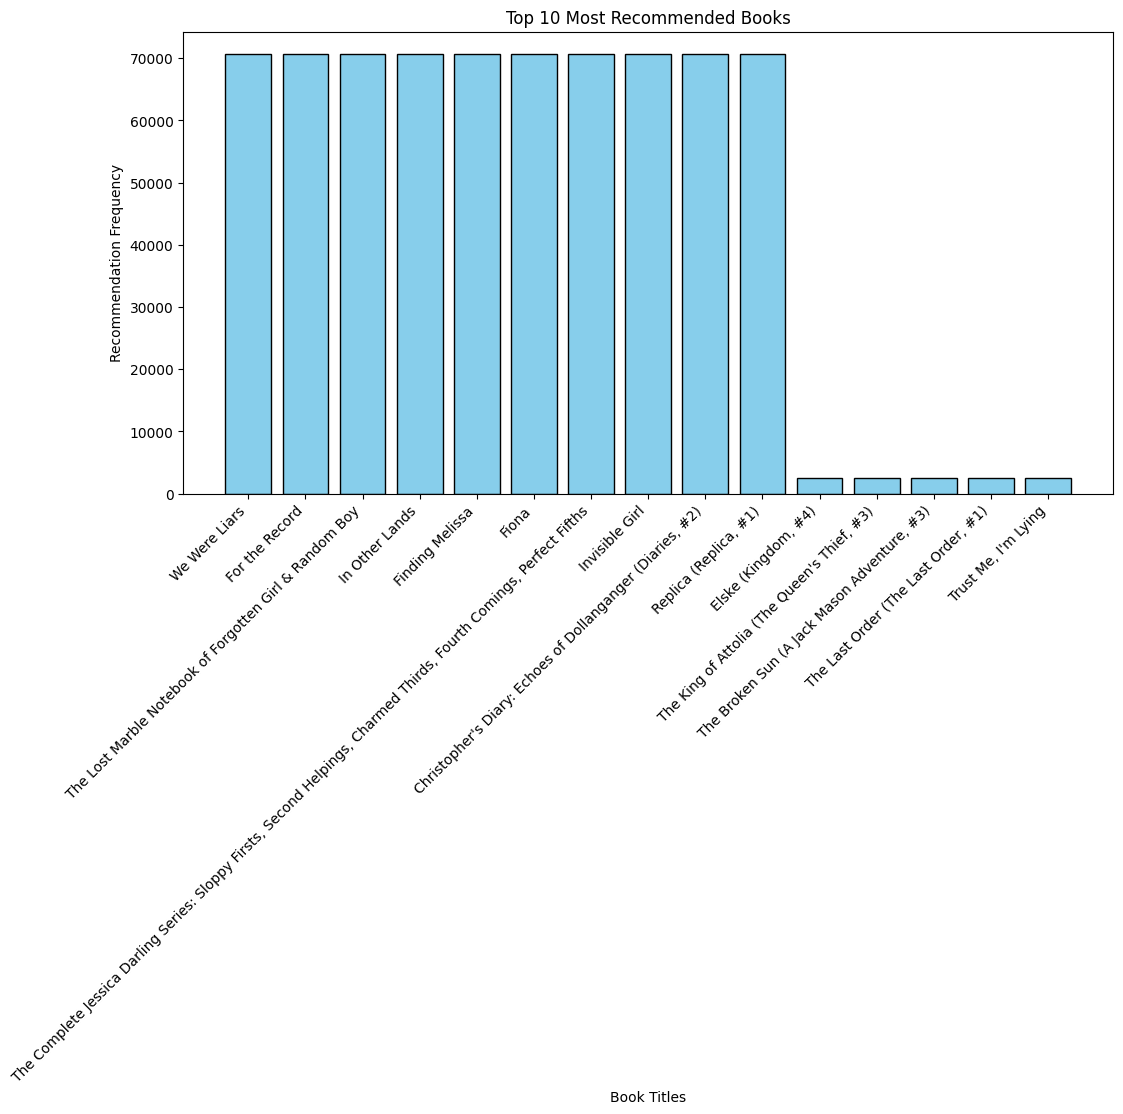

In [ ]:

flat_recs = test['bandit_recs_loaded'].to_numpy().flatten()
recs_df = pl.DataFrame({"item_id": flat_recs})

freq_df = recs_df.group_by("item_id").agg(count=pl.col("item_id").count()).sort("count", descending=True)



top_10_df = freq_df.head(15).join(books.select(["item_id", "title"]), on="item_id", how="left")
titles = top_10_df["title"].to_list()
counts = top_10_df["count"].to_list()


plt.figure(figsize=(12, 6))
plt.bar(titles, counts, color="skyblue", edgecolor="black")
plt.xlabel("Book Titles")
plt.ylabel("Recommendation Frequency")
plt.title("Top 10 Most Recommended Books")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Как можно видеть на гистограмме есть топ 10 айтемов (рандомных) которые рекомендуются по 7 тысяч раз, далее идет провал и следующие айтемы рекомендуются уже менее чем 600 раз.

Поскольку алгоритм рандомный то особой логики  искать не стоит, как видно в топе есть серийные книги, причем серия не 1я (логики в том что мы рекомендуем юзеру не читавшему 1ю часть книги (например Elske или the King of Attolia, The Broken Sun) сразу 3ю или 4ю часть тоже особо нет) 

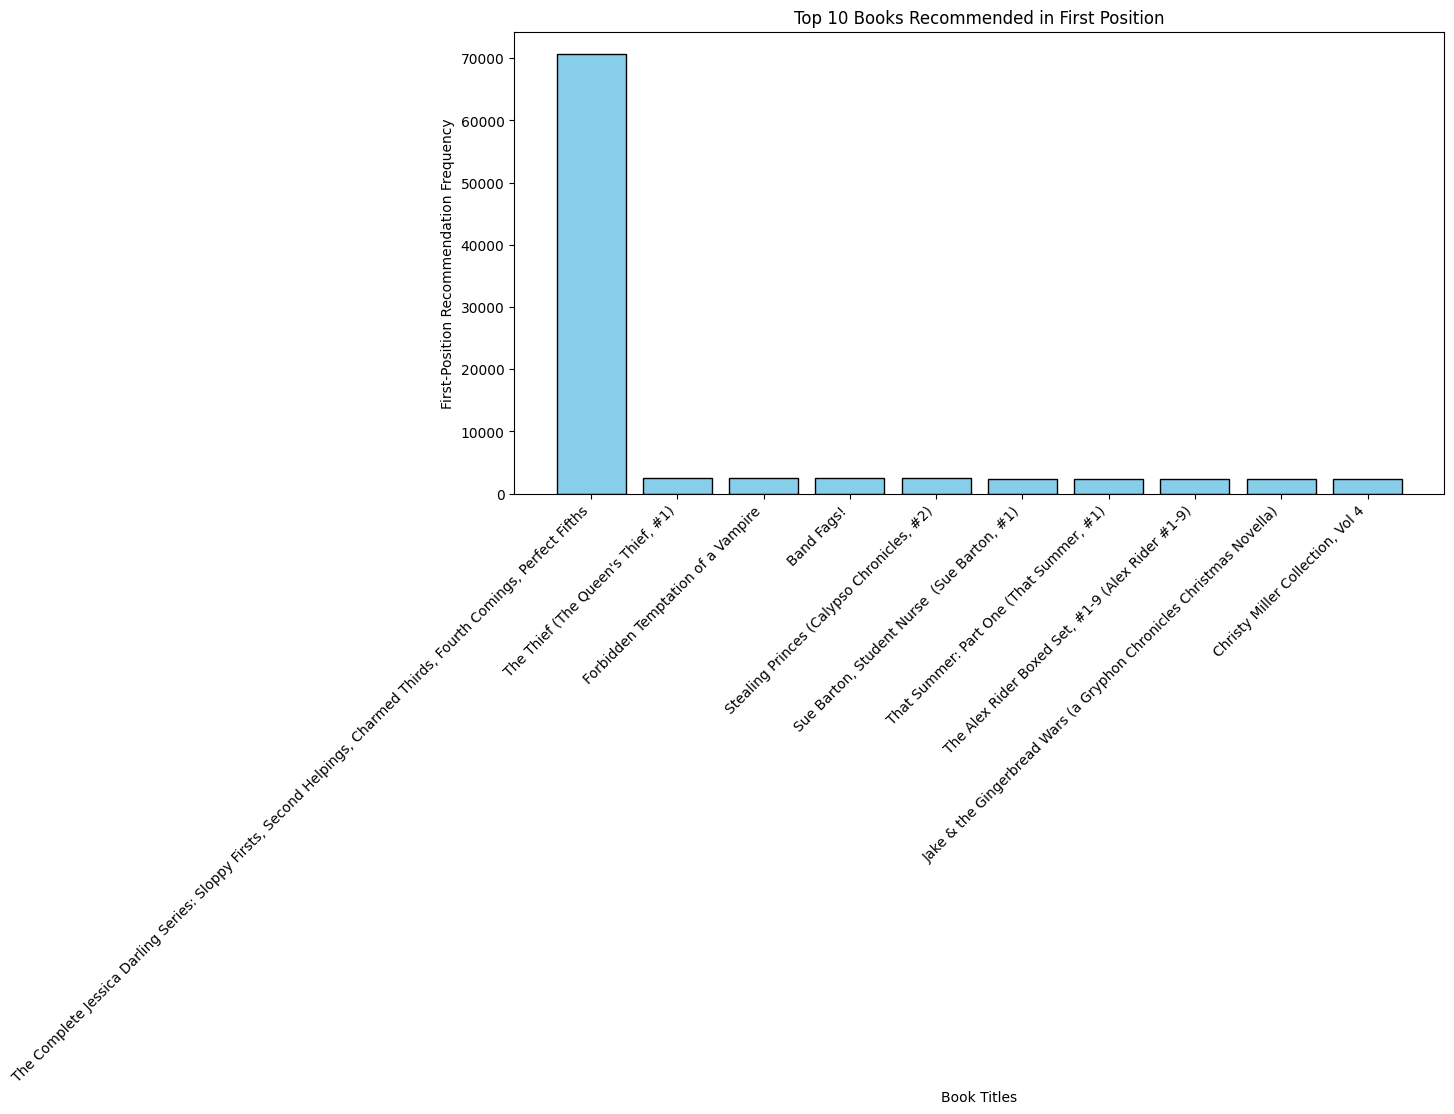

In [51]:
first_position_recs = test['bandit_recs_loaded'].to_numpy()[:, 0]

# Create Polars DataFrame for first-position recommendations
recs_df = pl.DataFrame({"item_id": first_position_recs})

# Count frequency of each item_id in first position
freq_df = recs_df.group_by("item_id").agg(count=pl.col("item_id").count()).sort("count", descending=True)

# Load Books DataFrame (assuming it's already in Polars format)
# Replace with your actual Books DataFrame


# Get top 10 most frequent first-position items and join with Books to get titles
top_10_df = freq_df.head(10).join(books.select(["item_id", "title"]), on="item_id", how="left")

# Handle missing titles by replacing nulls with "Unknown Title"
top_10_df = top_10_df.with_columns(pl.col("title").fill_null("Unknown Title"))

# Prepare data for plotting
titles = top_10_df["title"].to_list()
counts = top_10_df["count"].to_list()

# Create histogram using Matplotlib with same style as previous
plt.figure(figsize=(12, 6))
plt.bar(titles, counts, color="skyblue", edgecolor="black")
plt.xlabel("Book Titles")
plt.ylabel("First-Position Recommendation Frequency")
plt.title("Top 10 Books Recommended in First Position")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Явный лидер по рекомендации на 1й позиции

## EDA по рекомендованым товарам

/home/gleb_galagan/tbank_recsys/methods


## Thompson Sampling

In [23]:
import polars as pl
import numpy as np
from tqdm import tqdm
from collections import defaultdict


class ThompsonSamplingRecommender:
    def __init__(self):
        self.trained = False
        self.user_item_alpha_beta = None
        self.items_item_ids = None

    def fit(
        self,
        df: pl.DataFrame,
        items_df: pl.DataFrame,
        item_id_col: str = "item_id",
        user_id_col: str = "user_id",
        rating_col: str = "rating",
    ) -> None:
        """
        Fit Thompson Sampling priors from user-item interactions.
        """
        self.items_item_ids = items_df[item_id_col].to_numpy()

        # store alpha/beta for each user-item
        user_item_alpha_beta = defaultdict(lambda: [1, 1])  # prior α=1, β=1

        for row in df.iter_rows(named=True):
            u = row[user_id_col]
            i = row[item_id_col]
            r = row[rating_col]

            if r > 0:  # positive feedback
                user_item_alpha_beta[(u, i)][0] += 1
            else:  # negative/no feedback
                user_item_alpha_beta[(u, i)][1] += 1

        self.user_item_alpha_beta = user_item_alpha_beta
        self.trained = True

    def _sample_scores_for_user(self, user_id: str) -> np.ndarray:
        """
        Sample from Beta distributions for all items for a given user.
        """
        scores = []
        for item_id in self.items_item_ids:
            α, β = self.user_item_alpha_beta[(user_id, item_id)]
            sampled = np.random.beta(α, β)
            scores.append(sampled)
        return np.array(scores)

    def predict(
        self,
        df: pl.DataFrame,
        topn: int = 10,
        batch_size: int = 5000,
        user_id_col: str = "user_id",
    ) -> list[np.ndarray]:
        """
        Recommend topN items for each user via Thompson Sampling.
        """
        assert self.trained

        predictions = []
        n_users = len(df)

        for batch_start in tqdm(range(0, n_users, batch_size)):
            batch_end = min(batch_start + batch_size, n_users)
            batch_users = df[user_id_col][batch_start:batch_end].to_list()

            for u in batch_users:
                scores = self._sample_scores_for_user(u)
                top_indices = np.argpartition(-scores, topn)[:topn]
                rec_items = self.items_item_ids[top_indices]
                predictions.append(rec_items)

        return predictions


In [24]:
ts = ThompsonSamplingRecommender()
ts.fit(train, books)

test = test.with_columns(
    ts_recs=pl.Series(ts.predict(test, topn=10))
)
print(test.head())
evaluate_recommender(df=test, model_preds_col="ts_recs")


KeyboardInterrupt: 